In [1]:
import matplotlib.pyplot       as plt
import matplotlib.colors       as mcolors
import matplotlib.patches      as mpatches
import matplotlib.transforms   as mtransforms
import matplotlib.font_manager as font_manager
%matplotlib inline

In [2]:
import os
import h5py
import regex
import numpy as np

In [3]:
from crystfel_stream_parser.engine import StreamParser
from crystfel_stream_parser.cheetah_converter import CheetahConverter

In [4]:
path_stream = 'userdata/cxic0415/cwang31/psocake/r0101/cxic0415_0101.stream'
stream_parser = StreamParser(path_stream)

In [5]:
stream_record_dict = stream_parser.parse(num_cpus = 10)

2024-03-07 22:47:04,305	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


In [6]:
stream_record_idx = 50

In [7]:
geom_block = stream_record_dict[stream_record_idx]['GEOM_BLOCK']
cheetah_converter = CheetahConverter(geom_block)

In [8]:
basedir = 'userdata'
chunk_block = stream_record_dict[stream_record_idx]['CHUNK_BLOCK']
path_cxi = os.path.join(basedir, chunk_block['metadata']['Image filename'])
cxi_event_idx = int(os.path.join(basedir, chunk_block['metadata']['Event'])[2:])

In [9]:
with h5py.File(path_cxi, 'r') as f:
    psana_event_idx = f.get('LCLS/eventNumber')[cxi_event_idx]
    cxi_img = f.get('entry_1/data_1/data')[cxi_event_idx]

In [10]:
psana_event_idx

110

In [11]:
detector_img = cheetah_converter.convert_to_detector_img(cxi_img)

In [12]:
detector_img.shape

(1739, 1747, 1)

In [13]:
def display_img(img, scale = 14):
    ncols, nrows = 1, 1
    fig   = plt.figure(figsize = (ncols * scale, nrows * scale))
    gspec = fig.add_gridspec( nrows, ncols )
    ax_list = [ fig.add_subplot(gspec[i, j], aspect = 1) for i in range(nrows) for j in range(ncols)]

    ax = ax_list[0]

    vmin = np.nanmean(img) - 0 * np.nanstd(img)
    vmax = np.nanmean(img) + 4 * np.nanstd(img)
    im = ax.imshow(img, vmin = vmin, vmax = vmax)

    # ax.invert_xaxis()
    ax.invert_yaxis()

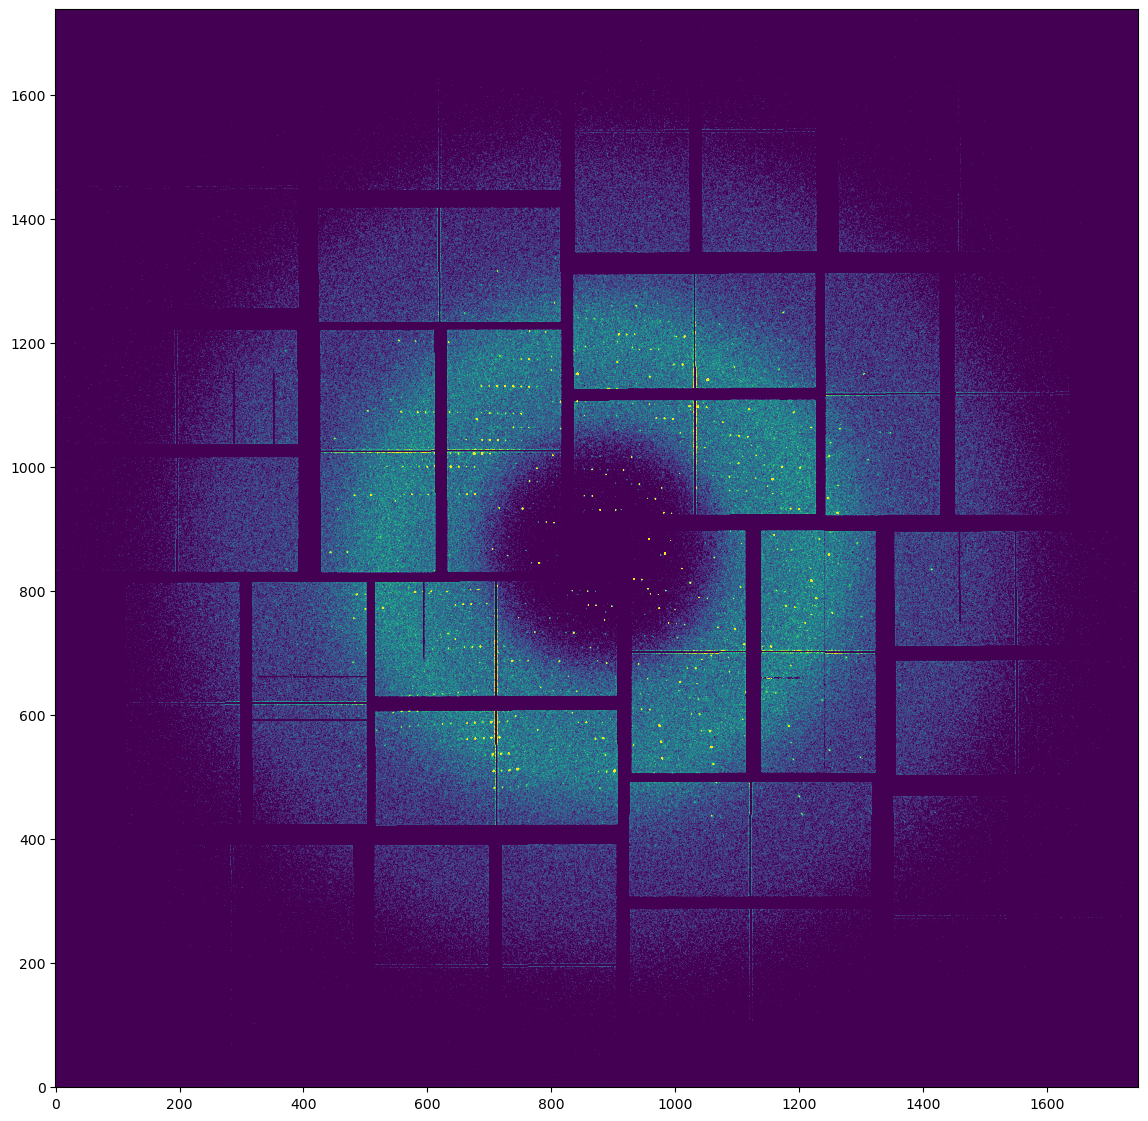

In [14]:
display_img(detector_img, scale = 14)